In [2]:
# for debugging the environment if got import error
sys.path.insert(0, '')

In [1]:
import os, sys
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import whoosh
import gensim

from collections import defaultdict
from whoosh import index, writing
from whoosh.qparser import QueryParser
from whoosh.fields import Schema, TEXT, STORED
from gensim.models import Word2Vec
from queue import PriorityQueue
from heapq import nlargest
from time import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Load keywords file

In [14]:
KEYWORD_FILE = 'computer_science_keywords.csv'
KEYWORDS = pd.read_csv(KEYWORD_FILE, header=None, index_col=False)
KEYWORDS.drop(columns=[2, 3, 4, 5], inplace=True)
KEYWORDS.rename(columns={0: 'terms', 1: 'num'}, inplace=True)
KEYWORDS['terms'] = KEYWORDS['terms'].astype(str)
KEYWORDS.head()

,terms,num
0,machine learning,5933
1,genetic algorithm,5264
2,classification,4532
3,deep learning,4371
4,data mining,4369


In [15]:
keyword_freq = {}
for term, num in zip(KEYWORDS['terms'], KEYWORDS['num']):
    if num.isdigit():
        keyword_freq[term] = int(num)
    else:
        keyword_freq[term] = 0

del KEYWORDS

### Retrieve concept terms from abstract

In [3]:
# light model for preprocessing the text
# nlp = spacy.load('en_core_web_sm')
# model that can be also used for word and doc embedding
nlp = spacy.load("en_core_web_md")

In [142]:
def ngram(input_list, ngram_num):
    '''Create a list of ngrams given a list of words.'''
    ngram_list = []
    if len(input_list) < ngram_num:
        ngram_list.append(input_list)
    else:
        for tmp in zip(*[input_list[i:] for i in range(ngram_num)]):
            ngram = ''
            for word in tmp:
                ngram += word + ' '
            ngram_list.append(ngram[:-1])
    return ngram_list

def find_ngram(nouns):
    '''Find any possible keyword in the input list. Longer keywords have higher priority.'''
    for i in reversed(range(1,len(nouns)+1)):
        ngram_list = ngram(nouns, i)
        for term in ngram_list:
            if term in keyword_freq:
                return term
    return None

def find_concept_terms(abstract):
    '''Return a str of dict containing keywords and their position from an abstract.'''
    doc = nlp(abstract)
    terms = defaultdict(lambda: [])
    nouns = []
    for i,token in enumerate(doc):
        if token.pos_ == 'NOUN':
            nouns.append(token.text.lower())
        elif nouns:
            term = find_ngram(nouns)
            if term:
                terms[term].append(i)
            nouns = []
    if nouns:
        term = find_ngram(nouns)
        if term:
            terms[term].append(i)
    return repr(dict(terms))

### Design search engine and read documents

In [4]:
schema = Schema(abstract=TEXT(),tags=STORED())

INDEX_FOLDER = 'index_data'
if not os.path.exists(INDEX_FOLDER):
    os.mkdir(INDEX_FOLDER)
    paper_index = index.create_in(INDEX_FOLDER, schema)
else:
    paper_index = index.open_dir(INDEX_FOLDER)

def clear_index(index):
    writer = index.writer()
    writer.commit(mergetype=writing.CLEAR)

In [147]:
DATA_FILE = 'arxiv-metadata-oai-snapshot.json'
start = 900001
num_paper = 1000000
file = open(DATA_FILE, 'r')
writer = paper_index.writer()
count = 0

for line in file.readlines():
    if count > num_paper:
        break
    if count < start:
        if count == start - 1:
            print('start to process')
        count += 1
        continue

    paper = json.loads(line)
    abstract = paper['abstract'].strip().lower().replace('-\n', '').replace('\n', ' ')
    tags = find_concept_terms(abstract)

    writer.add_document(abstract=abstract,tags = tags)

    count += 1
    if count % 10000 == 0:
        print('Complete %d files' % count)

print('start to commit...')
writer.commit()
print('finish commiting')
file.close()

start to process
Complete 910000 files
Complete 920000 files
Complete 930000 files
Complete 940000 files
Complete 950000 files
Complete 960000 files
Complete 970000 files
Complete 980000 files
Complete 990000 files
Complete 1000000 files
start to commit...
finish commiting


## Rank concepts

entity243 is good and equivalent to entity3825

apple data order
What is entity243(apple) equivalent to?
How people think of apple
entity3825

### Ranking formula:
$$\text{Score}_q(t) = (1-\alpha) P_q(t|D) + \alpha P(t|\bar{S}),$$
where 
$$P_q(t|D) = \sum_{d\in D} P_q(t|d) \\ P(t|d) = \frac{\log{\text{bm25}_d(q)} * \text{freq}_d(t)}{\text{freq}_D(t)^{k1} \text{sim}(t,q)^{k2}},$$
and
$$P(t|\bar{S})\equiv 0.05+\parallel\text{sim}(t,S) \parallel_{10}^{-2} = 0.05+\sqrt[5]{\sum_{s\in S} \text{sim}(t,s)^{-10}}.
$$

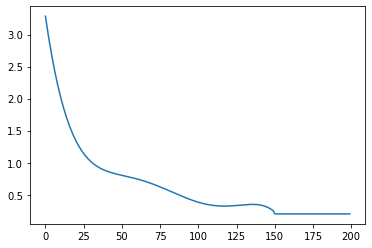

In [5]:
def relu(x):
    return x * (x > 0)
X = np.arange(16) * 10
Y = np.array([3.3,1.98,1.38,0.99,0.86,0.81,0.77,0.7,0.52,0.42,0.4,0.37,0.35,0.33,0.3,0.25])
Y = (Y - 0.2)
z = np.polyfit(X, Y, 5)
p = np.poly1d(z)

# the probability between span and relevance
def span_prox(s):
    return p(s) * (s < 150) + 0.2
plt.plot(span_prox(np.arange(200)))
plt.show()

In [6]:
def prob(word_position, key_position):
    '''Return the total probability of the word and the keyword being related.'''
    p = 0
    for key_pos in key_position:
        p += span_prox(np.abs(word_position - key_pos)).sum()
    return p

In [7]:
qp = QueryParser("abstract", schema=schema)
def search(s, word):
    '''Return a generator of searched results and word occurance'''
    q = qp.parse(word)
    
    matcher = q.matcher(s)
    # brutal force actually faster than priority queue
    positions = {}
    while matcher.is_active():
        start = tuple([span.start for span in matcher.spans()])
        positions[start] = matcher.score()
        matcher.next()
    positions = sorted(positions.items(), key=lambda kv: kv[1], reverse=True)
    positions = [np.array(elem[0]) for elem in positions]
    
    results = s.search(q, limit=5000)
    return zip(results,positions)

In [5]:
def soft_freq(prob, freq):
    return prob / np.sqrt(freq)
def hard_freq(prob, freq):
    return prob / freq ** 1.05
def soft_dif_word(value, target, concept):
    return value / (compare_similarity(target, concept) + 1)
def hard_dif_word(value, target, concept):
    return value / (compare_similarity(target, concept) + 0.2) ** 2
def soft_sim_word(value, target, concept):
    return value * (compare_similarity(target, concept) + 1)
def hard_sim_word(value, target, concept):
    return value * (compare_similarity(target, concept) + 0.2) ** 2
freq_f = {'soft freq': soft_freq, 'hard freq': hard_freq}
sim_f = {'soft dif': soft_dif_word, 'hard dif': hard_dif_word, 'soft sim': soft_sim_word, 'hard sim': hard_sim_word}

In [6]:
w2v_model = Word2Vec.load('word2vec_model/word2vec.model')
def lemmatize(concept):
    doc = nlp(concept)
    txt = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return ('_'.join(txt)).replace('datum', 'data')
def compare_similarity(word1, word2):
    try:
        return abs(w2v_model.wv.similarity(word1, word2))
    except:
        out = nlp(word1.replace('_', ' ')).similarity(nlp(word2.replace('_', ' ')))
        if not out:
            out = 0.05
        return out
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

In [7]:
def diversify(concepts, k, alpha):
    out = []
    concept_len = len(concepts)
    if concept_len == 0:
        return []

    sim_table = np.zeros((concept_len, k))
    concept_value = normalize(np.array(list(concepts.values())))
    concept_id = list(concepts.keys())
    
    for i in range(k):
        norm = np.linalg.norm(sim_table, ord=10, axis=1) ** 2 + 0.05
        norm = normalize(1/norm)
        temp = concept_value * (1-alpha) +  norm * alpha
        argmax = temp.argmax()

        concept = concept_id.pop(argmax)
        out.append(concept)
        sim_table = np.delete(sim_table,argmax,axis=0)
        concept_value = np.delete(concept_value,argmax,axis=0)

        min_sim = 0
        for j in range(concept_len - i - 1):
            sim = compare_similarity(concept, concept_id[j])
            sim_table[j,i] = sim
    
    return out

In [8]:
# load file
keyword_actual_freq = np.load('keyword_freq.npy', allow_pickle='TRUE').item()

In [9]:
qp = QueryParser("abstract", schema=schema)
def rank(s, word, freq_function='auto', word_function='', k=10, diverse=True, alpha=0.5):
    '''Rank all concept words.'''
    
    # sum their probability
    r = defaultdict(lambda: 0)

    '''
    # take account the factor of distance between words
    for hit,position in search(s, word):
        tags = eval(hit['tags'])
        for keyword, key_position in tags.items():
            r[keyword] += prob(position, key_position) # evaluate relevance by their spans
    '''

    q = qp.parse(word)
    results = s.search(q, limit=20000)
    for hit in results:
        tags = eval(hit['tags'])
        score = np.log(hit.score)
        for keyword, key_position in tags.items():
            r[keyword] += score * len(key_position)

    if freq_function == 'auto':
        count = len(results)
        if count > 1000:
            freq_function = 'hard freq'
        elif count >= 10:
            freq_function = 'soft freq'
        else:
            freq_function = ''
    
    # further calculation
    r = dict(r)
    r.pop(word, '')

    topwords = defaultdict(int)
    for concept,probability in nlargest(600, r.items(), key=lambda x: x[1]):
        value = probability
        # adjust by freq of concept terms
        if freq_function in freq_f:
            value = freq_f[freq_function](value, keyword_actual_freq[concept])
        # adjust by similarity
        if word_function in sim_f:
            value = sim_f[word_function](value, word, concept)
        topwords[lemmatize(concept)] += value
    topwords = dict(topwords)
    topwords.pop('', '')
    
    if diverse and 1 > alpha and 0 < alpha:
        return diversify(topwords, k, alpha)
    return nlargest(k, topwords.items(), key=lambda x: x[1])

In [10]:
def show_time_s(t):
    print('finished in {} seconds'.format(round((time() - t), 3)))
    return time()

In [21]:
with paper_index.searcher() as s:
    #word = 'panopticon' # 1
    #word = 'crnn' # 12
    #word = 'agriculture' # 175
    #word = 'soil' # 436
    #word = 'rl' # 677
    #word = 'compression' # 4796
    word = 'electromagnetic'
    print(word)
    t = time()
    print(rank(s, word, diverse=False))
    t = show_time_s(t)
    print(rank(s, word))
    t = show_time_s(t)
    try:
        print(w2v_model.wv.most_similar(word.replace(' ', '_')))
    except:
        print('%s not in the model' % word)
    t = show_time_s(t)

electromagnetic
[('maxwell_equation', 0.4749767281113908), ('cloak', 0.4300841292782278), ('electromagnetism', 0.39382796215394), ('metamaterial', 0.3229241860425833), ('em', 0.28350851072408473), ('permittivity', 0.2276361626340059), ('quantum_electrodynamic', 0.21773908168262363), ('form_factor', 0.21204209504644117), ('cascade', 0.1964064364972067), ('wave', 0.1957129560070033)]
finished in 4.367 seconds
['maxwell_equation', 'cloak', 'electromagnetism', 'metamaterial', 'em', 'form_factor', 'cascade', 'permittivity', 'wave', 'quantum_electrodynamic']
finished in 8.105 seconds
[('electromagnetic_field', 0.6270819306373596), ('electromagnetic_radiation', 0.6187474727630615), ('electromagnetic_wave', 0.5709630250930786), ('electric', 0.5479849576950073), ('em', 0.5152329206466675), ('electrodynamic', 0.5121166706085205), ('radiation', 0.49558883905410767), ('magnetic_dipole', 0.48694825172424316), ('gravitational_wave', 0.47556033730506897), ('gravitational', 0.47068583965301514)]
finis

In [160]:
# keyword freq
keyword_actual_freq = defaultdict(lambda:0)
with paper_index.searcher() as s:
    all_doc = s.documents()
    for doc in all_doc:
        tags = eval(doc['tags'])
        for tag, occurence in tags.items():
            keyword_actual_freq[tag] += len(occurence)
# save to file
keyword_actual_freq = dict(keyword_actual_freq)
np.save('keyword_freq.npy', keyword_actual_freq)